In [1]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[len(line) - 2])
            labels.append([t, 1-t])
            sentences.append(line[:len(line) - 4].strip())
    return labels, sentences


train_labels, train_data = read_data('./dataset.txt')
# val_labels, val_data = read_data('./examples/datasets/mc_dev_data.txt')
#  test_labels, test_data = read_data('./examples/datasets/mc_test_data.txt')

In [3]:
train_data[:5]

['cook creates complicated dish, experienced chef prepares complicated dish',
 'skilful programmer creates code, devoted hacker writes code',
 'skilful cook creates meal, devoted hacker creates complicated code',
 'hacker writes code, skilful hacker creates code',
 'devoted hacker writes code, hacker writes complicated code']

In [4]:
train_labels[:5]

[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0]]

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
#val_diagrams = parser.sentences2diagrams(val_data)
#test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


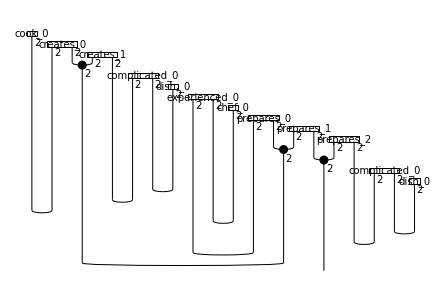

In [6]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
#val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
#test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

In [7]:
from lambeq import PytorchModel

all_circuits = train_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [8]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

In [9]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

#val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [11]:
trainer.fit(train_dataset, evaluation_step=1, logging_step=5)

Epoch 1:   train/loss: 0.6943   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 5:   train/loss: 0.6846   valid/loss: -----   train/acc: 0.5450   valid/acc: -----
Epoch 10:  train/loss: 0.6092   valid/loss: -----   train/acc: 0.5950   valid/acc: -----
Epoch 15:  train/loss: 0.4971   valid/loss: -----   train/acc: 0.6800   valid/acc: -----
Epoch 20:  train/loss: 0.1531   valid/loss: -----   train/acc: 0.9750   valid/acc: -----
Epoch 25:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 30:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----

Training completed!


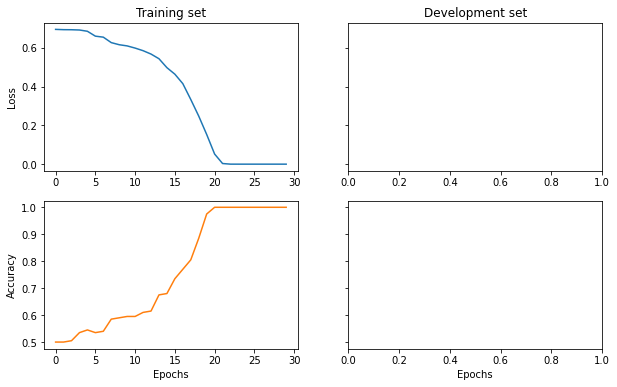

In [13]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(trainer.val_costs, color=next(colours))
#ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
#test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
#print('Test accuracy:', test_acc.item())

In [14]:
class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds)
        return preds

In [15]:
custom_model = MyCustomModel.from_diagrams(all_circuits)
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)
custom_model_trainer.fit(train_dataset, logging_step=5)

Epoch 1:   train/loss: 0.7023   valid/loss: -----   train/acc: 0.4650   valid/acc: -----
Epoch 5:   train/loss: 0.4476   valid/loss: -----   train/acc: 0.7600   valid/acc: -----
Epoch 10:  train/loss: 0.0181   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 15:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 20:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 25:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 30:  train/loss: 0.0000   valid/loss: -----   train/acc: 1.0000   valid/acc: -----

Training completed!


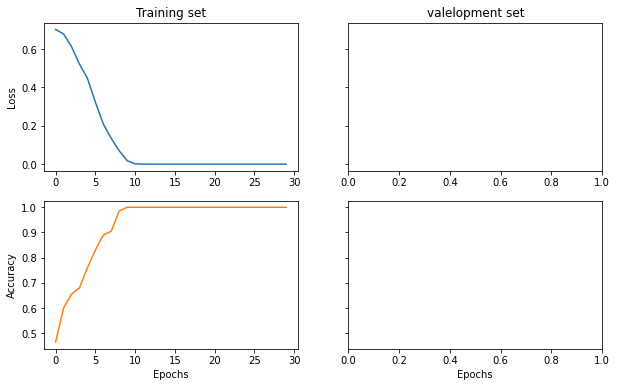

In [17]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('valelopment set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(custom_model_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(custom_model_trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(custom_model_trainer.val_costs, color=next(colours))
#ax_br.plot(custom_model_trainer.val_results['acc'], color=next(colours))

# print test accuracy
#test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
#print('Test accuracy:', test_acc.item())